Using `ipyparallel`
====

Parallel execution is tightly integrated with Jupyter in the `ipyparallel` package. Install with

```bash
conda install ipyparallel
ipcluster nbextension enable
```

[Official documentation](https://ipyparallel.readthedocs.org/en/latest/)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Starting engines

We will only use engines on local cores which does not require any setup - see [docs](https://ipyparallel.readthedocs.org/en/latest/process.html) for detailed instructions on how to set up a remote cluster, including setting up to use Amazon EC2 clusters.

You can start a cluster on the `IPython Clusters` tab in the main Jupyter browser window or via the command line with

```
ipcluster start -n <put desired number of engines to run here>
```

The main advantage of developing parallel applications using `ipyparallel` is that it can be done interactively within Jupyter.

## Basic concepts of `ipyparallel`

In [2]:
from ipyparallel import Client

The client connects to the cluster of "remote" engines that perfrom the actual computation. These engines may be on the same machine or on a cluster. 

In [3]:
rc = Client()

In [4]:
rc.ids

[0, 1, 2, 3]

A view provides access to a subset of the engines available to the client. Jobs are submitted to the engines via the view. A direct view allows the user to explicitly send work specific engines. The load balanced view is like the `Pool` object in `multiprocessing`, and manages the scheduling and distribution of jobs for you.

**Direct view**

In [5]:
dv = rc[:]

Add 10 sets of 3 numbers in parallel using all engines.

In [6]:
dv.map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Add 10 sets of 3 numbers in parallel using only alternate engines.

In [7]:
rc[::2].map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Add 10 sets of 3 numbers using a specific engine.

In [8]:
rc[2].map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

**Load balanced view**

Use this when you have many jobs that take different amounts of time to complete.

In [9]:
lv = rc.load_balanced_view()

In [10]:
lv.map_sync(lambda x: sum(x), np.random.random((10, 100000)))

[49994.025970164228,
 50046.764472770235,
 50133.164331916916,
 49992.347161748025,
 49885.373544323811,
 49885.083918586184,
 49947.790064880181,
 50098.901151785416,
 49932.720625110946,
 50012.012137623649]

#### Calling functions with apply

In contrast to `map`, `apply` is just a simple function call run on all remote engines, and has the usual function signature `apply(f, *args, **kwargs)`. It is a primitive on which other more useful functions (such as `map`) are built upon.

In [11]:
rc[1:3].apply_sync(lambda x, y: x**2 + y**2, 3, 4)

[25, 25]

In [12]:
rc[1:3].apply_sync(lambda x, y: x**2 + y**2, x=3, y=4)

[25, 25]

### Synchronous and asynchronous jobs

We have used the `map_sync` and `apply_sync` methods. The `sync` suffix indicate that we want to run a synchronous job. Synchronous jobs `block` until all the computation is done and return the result.

In [13]:
res = dv.map_sync(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [14]:
res

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In contrast, asynchronous jobs return immediately so that you can do other work, but returns a `AsyncMapResult` object, similar to the `future` object returned by the `concurrent.futures` package. You can query its status, cancel running jobs and retrieve results once they have been computed.

In [15]:
res = dv.map_async(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [16]:
res

<AsyncMapResult: <lambda>>

In [17]:
res.done()

True

In [18]:
res.get()

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

There is also a `map` method that by default uses asynchronous mode, but you can change this by setting the `block` attribute or function argument.

In [19]:
res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [20]:
res.get()

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Change blocking mode for just one job.

In [21]:
res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10), block=True)

In [22]:
res

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

Change blocking mode for this view so that all jobs are synchronous.

In [23]:
dv.block = True

In [24]:
res = dv.map(lambda x, y, z: x + y + z, range(10), range(10), range(10))

In [25]:
res

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27]


### Remote function decorators 

The `@remote` decorator results in functions that will execute simultaneously on all engines in a view. For example, you can use this decorator if you always want to run $n$ independent parallel MCMC chains.

In [26]:
with dv.sync_imports():
    import numpy

importing numpy on engine(s)


In [27]:
@dv.remote(block = True)
def f1(n):
    return numpy.random.rand(n)

In [28]:
f1(4)

[array([ 0.25638502,  0.821767  ,  0.49230098,  0.27223136]),
 array([ 0.93396935,  0.91080209,  0.55204118,  0.85168596]),
 array([ 0.64669385,  0.36201164,  0.43440278,  0.39976197]),
 array([ 0.5112765 ,  0.94966935,  0.11676516,  0.5513953 ])]

The @parallel decorator breaks up elementwise operations and distributes them.

In [29]:
@dv.parallel(block = True)
def f2(x):
    return x

In [30]:
f2(range(15))

[range(0, 4), range(4, 8), range(8, 12), range(12, 15)]

In [31]:
@dv.parallel(block = True)
def f3(x):
    return sum(x)

In [32]:
f3(range(15))

[6, 22, 38, 39]

In [33]:
@dv.parallel(block = True)
def f4(x, y):
    return x + y

In [34]:
f4(np.arange(10), np.arange(10))

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

####  Example: Use the `@parallel` decorator to speed up Mandelbrot calculations

In [35]:
def mandel1(x, y, max_iters=80):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [36]:
@dv.parallel(block = True)
def mandel2(x, y, max_iters=80):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [37]:
x = np.arange(-2, 1, 0.01)
y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y)

In [38]:
%%time
im1 = np.reshape(list(map(mandel1, X.ravel(), Y.ravel())), (len(y), len(x)))

CPU times: user 488 ms, sys: 4 ms, total: 492 ms
Wall time: 490 ms


In [39]:
%%time
im2 = np.reshape(mandel2.map(X.ravel(), Y.ravel()),  (len(y), len(x)))

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 236 ms


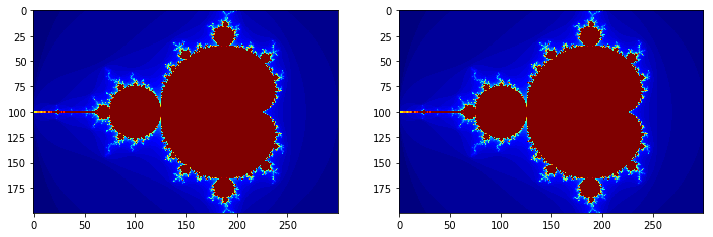

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].grid(False)
axes[0].imshow(im1, cmap='jet')
axes[1].grid(False)
axes[1].imshow(im2, cmap='jet')
pass

### Functions with dependencies

Modules imported locally are NOT available in the remote engines.

In [41]:
import time
import datetime

In [42]:
def g1(x):
    time.sleep(0.1)
    now = datetime.datetime.now()
    return (now, x)

This fails with an Exception because the `time` and `datetime` modules are not imported in the remote engines.

```python
dv.map_sync(g1, range(10))
```

The simplest fix is to import the module(s) *within* the function

In [43]:
def g2(x):
    import time, datetime
    time.sleep(0.1)
    now = datetime.datetime.now()
    return (now, x)

In [44]:
dv.map_sync(g2, range(5))

[(datetime.datetime(2018, 4, 3, 17, 7, 44, 420009), 0),
 (datetime.datetime(2018, 4, 3, 17, 7, 44, 520172), 1),
 (datetime.datetime(2018, 4, 3, 17, 7, 44, 420714), 2),
 (datetime.datetime(2018, 4, 3, 17, 7, 44, 420812), 3),
 (datetime.datetime(2018, 4, 3, 17, 7, 44, 420983), 4)]

Alternatively, you can simultaneously import both locally and in the remote engines with the `sync_import` context manager.

In [45]:
with dv.sync_imports():
    import time
    import datetime

importing time on engine(s)
importing datetime on engine(s)


Now the `g1` function will work.

In [46]:
dv.map_sync(g1, range(5))

[(datetime.datetime(2018, 4, 3, 17, 7, 44, 680257), 0),
 (datetime.datetime(2018, 4, 3, 17, 7, 44, 780431), 1),
 (datetime.datetime(2018, 4, 3, 17, 7, 44, 681845), 2),
 (datetime.datetime(2018, 4, 3, 17, 7, 44, 681740), 3),
 (datetime.datetime(2018, 4, 3, 17, 7, 44, 681121), 4)]

Finally, there is also a `require` decorator that can be used. This will force the remote engine to import all packages given.

In [47]:
from ipyparallel import require

In [48]:
@require('scipy.stats')
def g3(x):
    return scipy.stats.norm(0,1).pdf(x)

In [49]:
dv.map(g3, np.arange(-3, 4))

[0.0044318484119380075,
 0.053990966513188063,
 0.24197072451914337,
 0.3989422804014327,
 0.24197072451914337,
 0.053990966513188063,
 0.0044318484119380075]

### Moving data around

We can send data to remote engines with `push` and retrieve them with `pull`, or using the dictionary interface. For example, you can use this to distribute a large lookup table to all engines once instead of repeatedly as a function argument.

In [50]:
dv.push(dict(a=3, b=2))

[None, None, None, None]

In [51]:
def f(x):
    global a, b
    return a*x + b

In [52]:
dv.map_sync(f, range(5))

[2, 5, 8, 11, 14]

In [53]:
dv.pull(('a', 'b'))

[[3, 2], [3, 2], [3, 2], [3, 2]]

#### You can also use the dictionary interface as an alternative to push and pull

In [54]:
dv['c'] = 5

In [55]:
dv['a']

[3, 3, 3, 3]

In [56]:
dv['c']

[5, 5, 5, 5]

## Working with compiled code

### Numba

Using `numba.jit` is straightforward. See [example](https://github.com/barbagroup/numba_tutorial_scipy2016/blob/master/notebooks/10.optional.Numba.and.ipyparallel.ipynb)

### Cython

We need to do some extra work to make sure the shared libary compiled with cython is available to the remote engines:

- Compile a `named` shared module with the `-n` flag
- Use `np.ndarray[dtype, ndim]` in place of memroy views
    - for example, double[:] becomes np.ndarray[np.float64_t, ndim=1]
- Move the shared library to the `site-packages` directory
    - Cython magic moules can be found in `~/.cache/ipython/cython`
- Import the modules remtoely in the usual ways

In [57]:
%load_ext cython

In [58]:
%%cython -n cylib

import cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def f(np.ndarray[np.float64_t, ndim=1] x):
    x.setflags(write=True)
    cdef int i
    cdef int n = x.shape[0]
    cdef double s = 0

    for i in range(n):
        s += x[i]
    return s

#### Copy the compiled module in `site-packages` so that the remote engines can import it

In [59]:
import os
import glob
import site
import shutil
src = glob.glob(os.path.join(os.path.expanduser('~/'), '.cache', 'ipython', 'cython', 'cylib*so'))[0]
dst = site.getsitepackages()[0]
shutil.copy(src, dst)

'/opt/conda/lib/python3.6/site-packages/cylib.cpython-36m-x86_64-linux-gnu.so'

In [60]:
with dv.sync_imports():
    import cylib

importing cylib on engine(s)


Using parallel magic commands
----

In practice, most users will simply use the `%px` magic to execute code in parallel from within the notebook. This is the simplest way to use `ipyparallel`.

In [63]:
dv.map(cylib.f, np.random.random((6, 4)))

[2.004454672422404,
 1.3099785054553221,
 2.327825147722061,
 2.3836865333972415,
 1.937570747721396,
 1.7583638766908505]

### %px

This sends the command to all targeted engines.

In [64]:
%px import numpy as np
%px a = np.random.random(4)
%px a.sum()

Out[0:3]: 2.0034774866080221

Out[1:3]: 2.3929926622865723

Out[2:3]: 2.1577271084243281

Out[3:3]: 1.4882820529435226

#### List comprehensions in parallel

The `scatter` method partitions and distributes data to all engines. The `gather` method does the reverse. Together with `%px`, we can simulate parallel list comprehensions.

In [65]:
dv.scatter('a', np.random.randint(0, 10, 10))
%px print(a)

[stdout:0] [9 2 7]
[stdout:1] [5 6 1]
[stdout:2] [8 8]
[stdout:3] [1 0]


In [66]:
dv.gather('a')

array([9, 2, 7, 5, 6, 1, 8, 8, 1, 0])

In [68]:
dv.scatter('xs', range(24))
%px y = [x**2 for x in xs]
np.array(dv.gather('y'))

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529])

#### Running magic functions in parallel

[output:1]

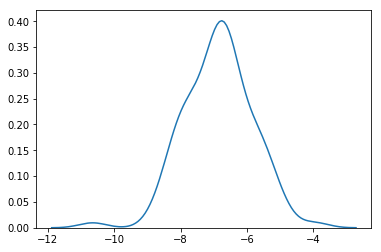

[output:3]

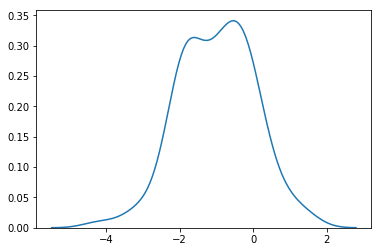

In [69]:
%%px --target [1,3]
%matplotlib inline
import seaborn as sns
x = np.random.normal(np.random.randint(-10, 10), 1, 100)
sns.kdeplot(x);

### Running in non-blocking mode

In [70]:
%%px --target [1,3] --noblock
%matplotlib inline
import seaborn as sns
x = np.random.normal(np.random.randint(-10, 10), 1, 100)
sns.kdeplot(x);

<AsyncResult: execute>

[output:1]

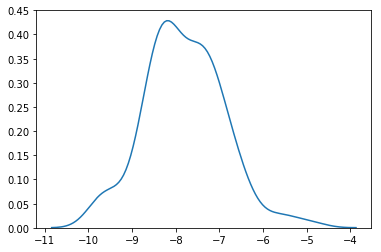

[output:3]

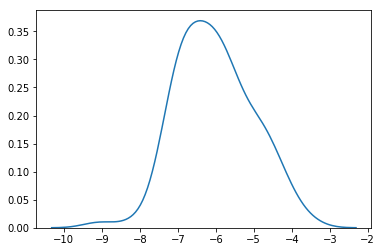

In [71]:
%pxresult

### Interacting with individual engines

We can interact with individual engines by calling the %qtconsole on each engine.

In [72]:
%px %qtconsole

Try looking at some of the variables defined in earlier cells - e..g `a`, `x`, `y` etc. Change the values directly in the console, then pull back into the notebook interface. Are the changes made preserved?